In [1]:
from learning_in_games import *

In [2]:
import igraph as ig

In [196]:
def get_update_indices(step, method, n_agents, uniform_size, fixed_independent_delays, initial_vector):
    if method == "uniform":
        random_vector = np.random.randint(0, high=uniform_size, size=n_agents)
        indices_to_update = np.where(random_vector == 0)
        return np.array(indices_to_update).flatten()
    elif method == "fixed":
        indices_to_update = np.where((step - initial_vector) % delay_parameter == 0)
        return np.array(indices_to_update).flatten()
    elif method == "fixed_independent":
        indices_to_update = np.where(((step - initial_vector) % fixed_independent_delays) == 0)
        return np.array(indices_to_update).flatten()

In [197]:
def imitate():
    for i in range(n_actions):
        other_actions = (np.ones(n_agents)*i).astype(int)
        other_rewards = np.ones(n_agents)*reward_per_action[i]
        Q, _ = bellman_update_q_table(Q, S, other_actions, other_rewards, S, agentConfig=imitationAgentConfig)

In [198]:
n_iter = 100000

In [203]:
n_agents = 100
n_states = 1
n_actions = 3
cost = 0  # for Braess, the cost of the crossing link, typically 0

gameConfig = RouteConfig(n_agents, n_actions, n_states, cost)

alpha = 0.1
alpha_imitation = 0.
gamma = 0
qinit = "UNIFORM"
epsilon = 0.01 # "DECAYED"
imitation = False

agentConfig = EpsilonGreedyConfig(alpha, gamma, qinit, epsilon)
imitationAgentConfig = EpsilonGreedyConfig(alpha_imitation, gamma, qinit, epsilon)

delay_method = "fixed_independent"
delay_parameter = 3

fixed_independent_delays = np.random.randint(0, high=delay_parameter, size=n_agents)

if delay_method == "fixed":
    initial_vector = np.random.randint(0, high=100, size=n_agents)
else:
    initial_vector = np.random.randint(0, high=delay_parameter, size=n_agents)

name = f"method({delay_method})_parameter({delay_parameter})"

In [204]:
Q = initialize_q_table(qinit, n_agents, n_states, n_actions, qmin=-2, qmax=-1)
exp_start, exp_end, exp_decay = initialize_exploration_rates(n_iter, gameConfig, agentConfig)
exp_decay_factor = 8
M = {}
ind = np.arange(gameConfig.n_agents)
S = np.random.randint(gameConfig.n_states, size=gameConfig.n_agents)

for t in range(n_iter):
    agentConfig.epsilon = update_exploration_rates(t, n_iter, exp_start=exp_start, exp_end=exp_end, exp_decay_factor=exp_decay_factor)
    
    A = e_greedy_select_action(Q, S, epsilon)

    R, _, reward_per_action = braess_augmented_network(A, n_agents, cost)
    # R = np.mean(R)

    indices_to_update = get_update_indices(t,
                                           delay_method,
                                           n_agents,
                                           uniform_size=delay_parameter,
                                           fixed_independent_delays=fixed_independent_delays,
                                           initial_vector=initial_vector)
    # print(indices_to_update)
    Q, sum_of_belief_updates = bellman_update_q_table(indices_to_update, Q, S, A, R, S, alpha, gamma)
    
    ## SAVE PROGRESS DATA
    M[t] = {
        "nA": np.bincount(A, minlength=gameConfig.n_actions),
        "R": R,
        "Q": Q[ind, S, A]
    }

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_67163/188269656.py:10: RuntimeWarning: divide by zero encountered in remainder
  indices_to_update = np.where(((step - initial_vector) % fixed_independent_delays) == 0)


In [205]:
x_vals = np.arange(0, n_iter, 1)
threshold = 0.5
W = np.array([-M[t]["R"].mean() for t in x_vals])[int(threshold*n_iter):-1]

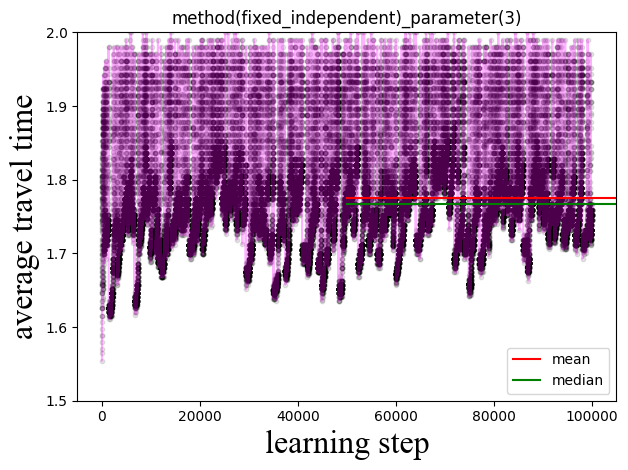

In [206]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
plt.plot(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.3, color="magenta")
plt.scatter(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.1, s=10, c="black")

mean = W.mean()
median = np.median(W)
ax.axhline(y=mean, xmin=threshold, xmax=1,label="mean", color="red")
ax.axhline(y=median, xmin=threshold, xmax=1, label="median", color="green")

plt.title(name)

plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("average travel time", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.legend()
plt.savefig(f"delay_experiments/braess_timeseries_{name}.png")

In [ ]:
np.random.normal(0, high=2, size=n_agents)

In [ ]:
signal = np.array([-M[t]["R"].mean() for t in x_vals])
signal[20000:-1]

In [ ]:
from scipy.fftpack import fft

# Number of samplepoints
N = len(signal)

# Sample spacing
T = 1.0

x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

yf = fft(signal)

xf = np.linspace(0.0, 1.0/(2*T), int(N/2))

plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))

In [ ]:
signal = signal - signal.mean()
sp = np.fft.fft(signal)
freq = np.fft.fftfreq(signal.shape[-1])
plt.plot(freq, np.abs(sp.real))
plt.yscale("log")

In [ ]:
np.argmax(np.abs(sp.real))

In [ ]:
freq[np.argmax(np.abs(sp.real))]

In [ ]:
1000000/(1/0.000031)